# Supervisé : Regression 



# Prédire le prix d'un nouveau produit selon les caracteristiques(XGBoost, Linear Regression, Decision Tree)

In [2]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor

import numpy as np

# 1. Connexion à SQL Server

conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=localhost;'  
    'DATABASE=SuplyChain_DataWarehouse;'
    'Trusted_Connection=yes;'
)

# 2. Requête SQL (features pertinentes uniquement)

query = """
SELECT 
    fs.Prix_Unitaire_TND_1, 
    fs.Quantite,
    cat.Category AS ProductCategory,
    b.brandname AS Brand,
    shop.shopname AS Shop,
    d.Year, d.Month,
    DATEDIFF(DAY, prod.ProductionStartDate_PK, prod.ProductionEndDate_PK) AS ProductionDuration,
    (
        SELECT COUNT(*) 
        FROM Fact_Dosage fd 
        WHERE fd.Prod_FK = p.Product_PK
    ) AS NbMaterials
FROM Fact_Sales fs
JOIN Dim_Product p         ON fs.Product_PK = p.Product_PK
JOIN Dim_Category cat      ON p.Category_FK = cat.Category_PK
JOIN Dim_Brand b           ON p.Brand_FK = b.Brand_PK
JOIN Dim_Shop shop         ON fs.Shop_PK = shop.Shop_PK
JOIN Dim_Date d            ON fs.Date_FK = d.Date_PK
LEFT JOIN fact_production prod ON prod.Product_PK = fs.Product_PK
"""


# 3. Charger les données

df = pd.read_sql(query, conn)
conn.close()



C:\Users\user\AppData\Local\Temp\ipykernel_35032\295622055.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:

# 4. Nettoyage et préparation

df.fillna({
    'ProductionDuration': 0,
    'NbMaterials': 0
}, inplace=True)

df = df[df['Prix_Unitaire_TND_1'] > 0]  # enlever cibles invalides



In [4]:
df

,Prix_Unitaire_TND_1,Quantite,ProductCategory,Brand,Shop,Year,Month,ProductionDuration,NbMaterials
0,160.630005,14,Makeup,hansen hopkins and smith,eclat studio,2024,04,23.0,4
1,160.630005,7,Makeup,hansen hopkins and smith,eclat studio,2024,10,23.0,4
2,160.630005,14,Makeup,hansen hopkins and smith,eclat studio,2024,04,23.0,4
3,160.630005,7,Makeup,hansen hopkins and smith,eclat studio,2024,10,23.0,4
4,160.630005,14,Makeup,hansen hopkins and smith,eclat studio,2024,04,23.0,4
...,...,...,...,...,...,...,...,...,...
23074,108.599998,16,Makeup,anthony colon and jimenez,eclat studio,2022,06,0.0,5
23075,147.199997,12,Bodycare,hansen hopkins and smith,beaute elegante,2023,02,0.0,2
23076,36.610001,16,Makeup,rogers thompson,cosmetiques radiance,2023,02,0.0,5
23077,36.610001,11,Makeup,rogers thompson,cosmetiques radiance,2023,10,0.0,5


In [5]:
# Variables explicatives (X) et cible (y)
X = df.drop(columns=["Prix_Unitaire_TND_1"])
y = df["Prix_Unitaire_TND_1"]



In [6]:
# Encodage des colonnes catégorielles
cat_cols = X.select_dtypes(include='object').columns

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])




In [7]:

# 5. Split des données

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:

# 6. Modèle XGBoost

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)


In [9]:
model.fit(X_train, y_train)

# 7. Évaluation du modèle

y_pred = model.predict(X_test)
df['Prix_Estimé'] = model.predict(X)


df['Ecart_Pourcentage'] = ((df['Prix_Estimé'] - df['Prix_Unitaire_TND_1']) / df['Prix_Unitaire_TND_1']) * 100
from sqlalchemy import create_engine

engine = create_engine("mssql+pyodbc://localhost/SuplyChain_DataWarehouse?driver=ODBC+Driver+17+for+SQL+Server")

df.to_sql("Estimation_Prix", engine, if_exists="replace", index=False)
print("✅ Résultat exporté vers table SQL : Estimation_Prix")


rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(" Évaluation du modèle (final optimisé) :")
print(f" RMSE  : {rmse:.2f} TND")
print(f" MAE   : {mae:.2f} TND")
print(f" R²    : {r2:.4f}")
print(f" MAPE  : {mape:.2f}%")






✅ Résultat exporté vers table SQL : Estimation_Prix
 Évaluation du modèle (final optimisé) :
 RMSE  : 12.29 TND
 MAE   : 2.21 TND
 R²    : 0.9480
 MAPE  : 4.38%


c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# 🔍 Performance sur train et test pour XGBoost
train_pred_xgb = model.predict(X_train)
test_pred_xgb = model.predict(X_test)

train_r2_xgb = r2_score(y_train, train_pred_xgb)
test_r2_xgb = r2_score(y_test, test_pred_xgb)

print(" XGBoost - R² Train :", train_r2_xgb)
print(" XGBoost - R² Test  :", test_r2_xgb)


 XGBoost - R² Train : 0.9922038451377962
 XGBoost - R² Test  : 0.9480485303276203


In [11]:
import joblib
joblib.dump(model, 'xgb_price_model.pkl')


['xgb_price_model.pkl']

<Figure size 1000x600 with 0 Axes>

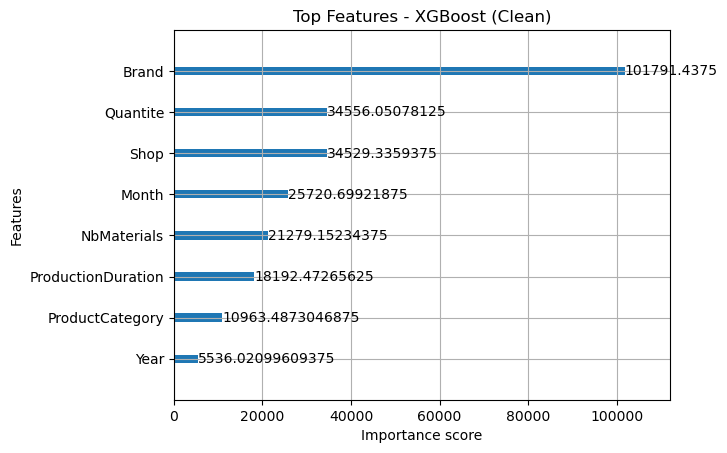

In [12]:

# 8. Feature Importance

plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top Features - XGBoost (Clean)")
plt.show()

In [13]:
from sklearn.tree import DecisionTreeRegressor

#  Créer le modèle
tree_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)


#  Entraîner le modèle sur les données d'entraînement
tree_model.fit(X_train, y_train)

#  Faire des prédictions sur les données de test
y_pred_tree = tree_model.predict(X_test)

#  Évaluer le modèle
print("MAE :", mean_absolute_error(y_test, y_pred_tree))
print("MSE :", mean_squared_error(y_test, y_pred_tree))
print("RMSE :", mean_squared_error(y_test, y_pred_tree) ** 0.5)
print("R² :", r2_score(y_test, y_pred_tree))


MAE : 2.4190576817592304
MSE : 179.78822141482485
RMSE : 13.408513020272787
R² : 0.9382048585989317


In [14]:
#  Performance sur train et test pour Decision Tree
train_pred_tree = tree_model.predict(X_train)
test_pred_tree = tree_model.predict(X_test)

train_r2_tree = r2_score(y_train, train_pred_tree)
test_r2_tree = r2_score(y_test, test_pred_tree)

print(" Decision Tree - R² Train :", train_r2_tree)
print(" Decision Tree - R² Test  :", test_r2_tree)


 Decision Tree - R² Train : 0.9748498917571449
 Decision Tree - R² Test  : 0.9382048585989317


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Colonnes
cat_cols = ['Brand', 'ProductCategory', 'Shop']
num_cols = [col for col in X.columns if col not in cat_cols]

#  Pipeline de prétraitement
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ("num", StandardScaler(), num_cols)
])

#  Pipeline complet
knn_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=5))  # tu peux ajuster k
])

#  Entraînement
knn_pipeline.fit(X_train, y_train)

#  Prédictions
y_pred_knn = knn_pipeline.predict(X_test)

#  Évaluation
print("KNN MAE :", mean_absolute_error(y_test, y_pred_knn))
print("KNN RMSE:", mean_squared_error(y_test, y_pred_knn, squared=False))
print(" KNN R²  :", r2_score(y_test, y_pred_knn))
y_train_pred_knn = knn_pipeline.predict(X_train)

print("KNN - R² Train :", r2_score(y_train, y_train_pred_knn))
print("KNN - R² Test  :", r2_score(y_test, y_pred_knn))



KNN MAE : 2.1225914195257416
KNN RMSE: 12.509835023278807
 KNN R²  : 0.9462106546164695


c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


KNN - R² Train : 0.9649149814868658
KNN - R² Test  : 0.9462106546164695
